# Summary

---
This example code is part of my thesis 'Low voltage load forecasting using ensemble methods'. The data used are anonymized smart meter data from CKW (https://www.ckw.ch/landingpages/open-data). The anonymized ID used is '03466ed913455c281ffeeaa80abdfff6'.

---
This notebook has 7 parts:

1.   Exploratory analysis of the data
2.   Data preparation for forecasting
3.   Create and train the model
4.   Forecasting
5.   Forecast evaluation
6.   Residual analysis
7.   Conclusions

In [44]:
# Import Libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, BatchNormalization, Activation
from sklearn.metrics import mean_squared_error
import calendar

In [45]:
# Open file in a dataframe

df = pd.read_parquet('/content/drive/MyDrive/ckw_data_files/03466ed913455c281ffeeaa80abdfff6.parquet') # Please change the filepath according to your stograge

In [46]:
#Convert timestamp to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])
# Extracting date and time components
df['Date'] = df['timestamp'].dt.date
df['Time'] = df['timestamp'].dt.time

The dataframe is checked and as it does not contain missing timestamps and values one can proceed to exploratory analysis

# Data exploratory analysis

The daily pattern shall be checked by time series plots on an example day  (30 March) on different year to check the pattern

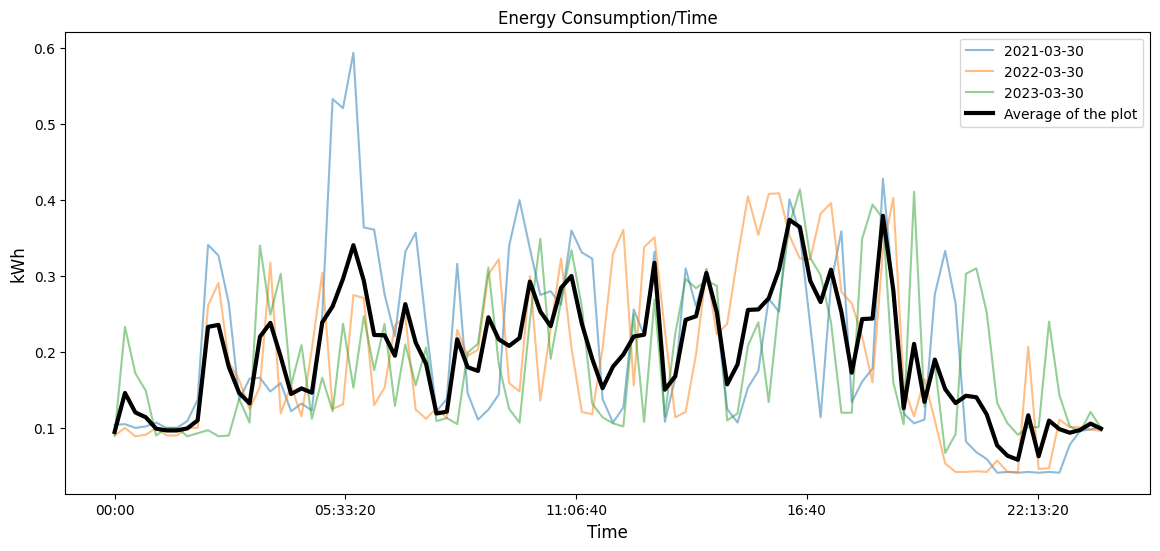

In [47]:
# Time series plots/ per different days
# Create the new DataFrame df2 which includes values by date
df_timeseries = df.pivot_table(index='Time', columns='Date', values='kwh')

# Reset the index and rename the columns
df_timeseries = df_timeseries.reset_index().rename_axis(columns=None)
selected_columns = [df_timeseries.columns[90], df_timeseries.columns[455], df_timeseries.columns[820]]

# Calculate the mean across the selected columns
average_series = df_timeseries[selected_columns].mean(axis=1)
# Plot timeseries
df_timeseries.plot(x='Time', y=[df_timeseries.columns[90],df_timeseries.columns[455],df_timeseries.columns[820]], figsize=(14, 6), legend=True, alpha=0.5)
plt.plot(df_timeseries['Time'], average_series, label='Average of the plot', color='black', linewidth=3)

plt.xlabel('Time', fontsize=12)
plt.ylabel('kWh', fontsize=12)
plt.title('Energy Consumption/Time')

# Move the legend to the top right
plt.legend(loc='upper right')

plt.show()

It seemms that the daily pattern has lower values during the night and higher values during the day. The pattern is similar for the same day in different years.

The same pattern can be evaluated for the same year(2022) in different season (March, June, September)

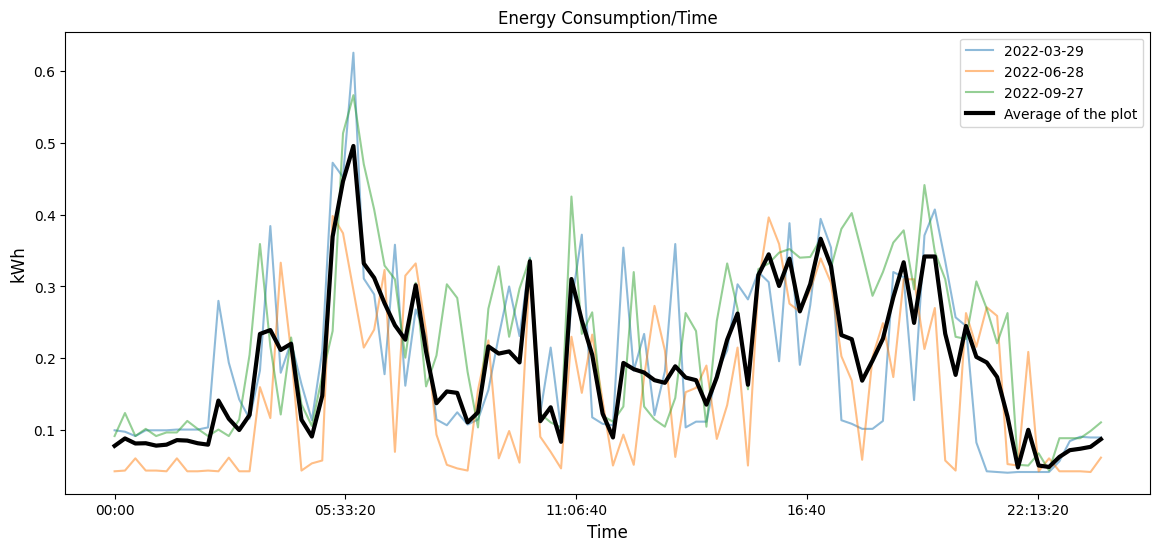

In [48]:
# Time series plots/ per different days
# Create the new DataFrame df2 which includes values by date
df_timeseries = df.pivot_table(index='Time', columns='Date', values='kwh')

# Reset the index and rename the columns
df_timeseries = df_timeseries.reset_index().rename_axis(columns=None)
# Reset the index and rename the columns

df_timeseries = df_timeseries.reset_index().rename_axis(columns=None)
selected_columns = [df_timeseries.columns[455],df_timeseries.columns[455+91],df_timeseries.columns[455+92+90]]

# Calculate the mean across the selected columns
average_series = df_timeseries[selected_columns].mean(axis=1)
# Plot timeseries
df_timeseries.plot(x='Time', y=[df_timeseries.columns[455],df_timeseries.columns[455+91],df_timeseries.columns[455+92+90]], figsize=(14, 6), legend=True, alpha=0.5)
plt.plot(df_timeseries['Time'], average_series, label='Average of the plot', color='black', linewidth=3)

plt.xlabel('Time', fontsize=12)
plt.ylabel('kWh', fontsize=12)
plt.title('Energy Consumption/Time')

# Move the legend to the top right
plt.legend(loc='upper right')

plt.show()

By the ACF plot, there is a high correlation at lag 96 (15 minute timestamp x 4 per hour x points x 24 hours) which indicates daily seasonality.

The high peaks on PACF plot at lag 96 but also lag 672 indicate daily but also weekly seasonality

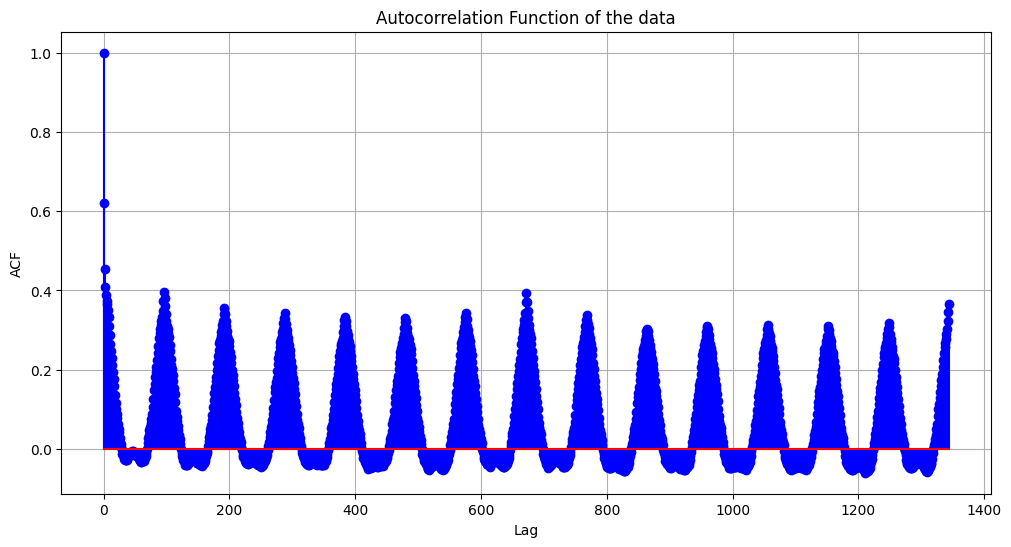

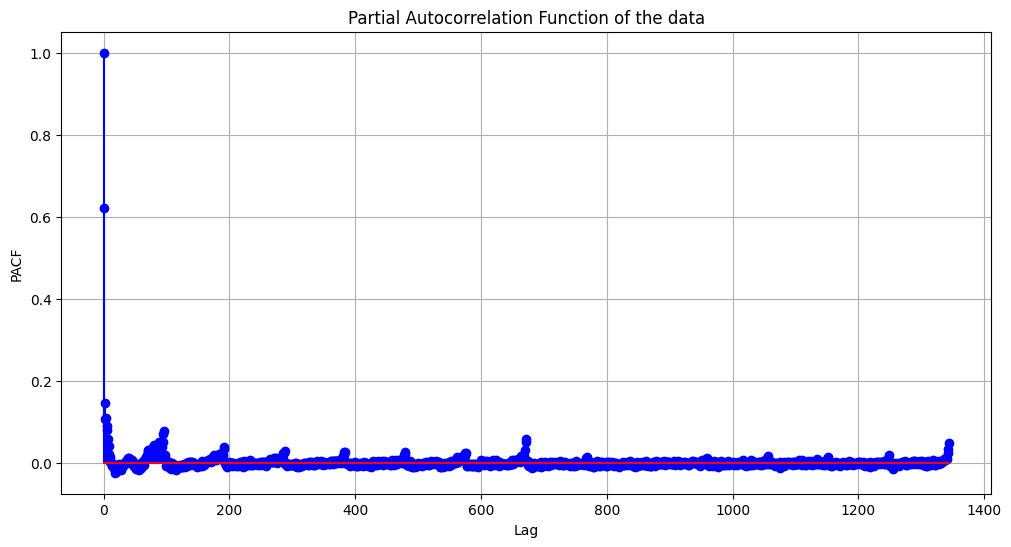

In [49]:
# Calculate ACF
acf_values = acf(df['kwh'], fft=False, nlags=1344)

# Calculate PACF
pacf_values = pacf(df['kwh'], nlags=1344)

# Plot ACF
plt.figure(figsize=(12, 6))
plt.stem(acf_values, linefmt='b-', markerfmt='bo', basefmt='r-')
plt.title('Autocorrelation Function of the data')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid(True)
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plt.stem(pacf_values, linefmt='b-', markerfmt='bo', basefmt='r-')
plt.title('Partial Autocorrelation Function of the data')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.grid(True)
plt.show()

To evaluate the weekly pattern MSTL decomposition is appropriate as the data seems to have multiple seasonalities

A subset of the data for year 2022 can be used

In [50]:
start_timestamp = pd.Timestamp('2022-01-01 00:00:00+00:00')
end_timestamp = pd.Timestamp('2022-12-31 23:45:00+00:00')
# Subset the DataFrame based on the specified range
df_2022 = df[(df['timestamp'] >= start_timestamp) & (df['timestamp'] <= end_timestamp)]
df_2022 = df_2022.reset_index(drop=True)

In [51]:
 # Run MSTL
mstl= MSTL(df_2022['kwh'], periods=(96, 96 * 7)) # apply both seasonalities
res = mstl.fit() # Residual component
seasonal = res.seasonal # contains both seasonal components
trend = res.trend
residual = res.resid

By plotting 2 weeks of the decomposition and besides the strong daily pattern, the weekly seasonal pattern can also be evaluated as the peaks within the plot of the weekly seasonal component are similar for both plotted weeks.

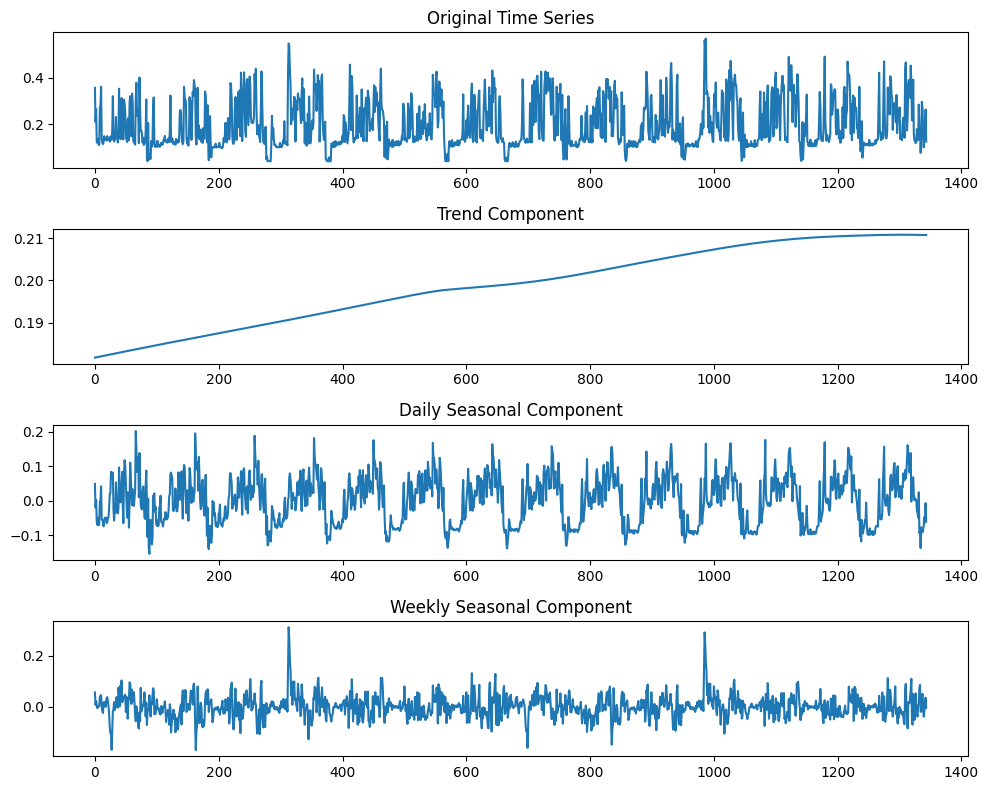

In [52]:
# Define the number of points you want to plot
num_points = 672 * 2

# Slice the components to the specified number of points
original_series = df_2022['kwh'][:num_points]
trend_component = res.trend[:num_points]
seasonal_component1 = res.seasonal.seasonal_96[:num_points]
seasonal_component2 = res.seasonal.seasonal_672[:num_points]

# Plot the original time series
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(original_series)
plt.title('Original Time Series')

# Plot the trend component
plt.subplot(4, 1, 2)
plt.plot(trend_component)
plt.title('Trend Component')

# Plot the seasonal component 1
plt.subplot(4, 1, 3)
plt.plot(seasonal_component1)
plt.title('Daily Seasonal Component')

# Plot the seasonal component 2
plt.subplot(4, 1, 4)
plt.plot(seasonal_component2)
plt.title('Weekly Seasonal Component')

plt.tight_layout()
plt.show()

The histogram for the 2022 values shows that the data is right skewed, it contains non negative values, and most of the observations are within the range of 0.005-0.2 kwh

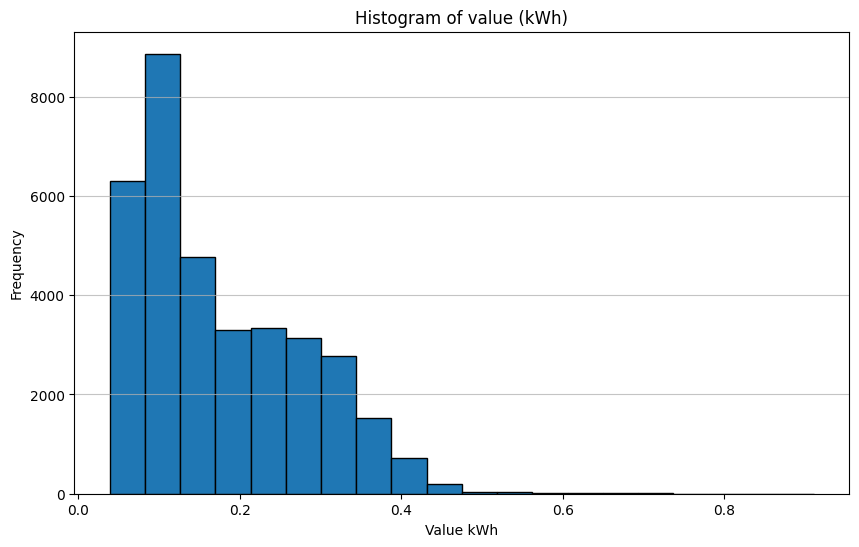

In [53]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_2022['kwh'], bins=20, edgecolor='black')
plt.title('Histogram of value (kWh)')
plt.xlabel('Value kWh')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Data preparation for forecasting

The data for training will be the year 2022 in order to try capturing all the seasonal patterns of the year. The rolling window method will be used to prepare the data with (window size of 1 week-step 1 day) for both training and testing. The input will be 1 week and the output one day ahead (forecasting horizon).

The test data will be year 2023 in which all the daily windows will be forecasted and evaluated.

The scaling method is the Standard scaler.

---



In [54]:
scaler = StandardScaler()
# Selecting columns to scale
columns_to_scale = ['kwh']
df_scaled = pd.DataFrame(scaler.fit_transform(df[columns_to_scale]), columns=[column + '_scaled' for column in columns_to_scale])
df = pd.concat([df, df_scaled], axis=1)

# Prepare the target variables by shifting the columns by 96 (1 day ahead)
df['target'] = df['kwh'].shift(-96)
df['target_scaled'] = df['kwh_scaled'].shift(-96)
df['target_timestamp'] = df['timestamp'].shift(-96)

In [55]:
df

,timestamp,kwh,Date,Time,kwh_scaled,target,target_scaled,target_timestamp
0,2020-12-31 23:45:00+00:00,0.137,2020-12-31,23:45:00,-0.415271,0.114,-0.630730,2021-01-01 23:45:00+00:00
1,2021-01-01 00:00:00+00:00,0.309,2021-01-01,00:00:00,1.195986,0.115,-0.621362,2021-01-02 00:00:00+00:00
2,2021-01-01 00:15:00+00:00,0.213,2021-01-01,00:15:00,0.296680,0.108,-0.686936,2021-01-02 00:15:00+00:00
3,2021-01-01 00:30:00+00:00,0.154,2021-01-01,00:30:00,-0.256019,0.112,-0.649465,2021-01-02 00:30:00+00:00
4,2021-01-01 00:45:00+00:00,0.131,2021-01-01,00:45:00,-0.471478,0.113,-0.640098,2021-01-02 00:45:00+00:00
...,...,...,...,...,...,...,...,...
110299,2024-02-19 21:45:00+00:00,0.131,2024-02-19,21:45:00,-0.471478,NaN,NaN,NaT
110300,2024-02-19 22:00:00+00:00,0.105,2024-02-19,22:00:00,-0.715040,NaN,NaN,NaT
110301,2024-02-19 22:15:00+00:00,0.105,2024-02-19,22:15:00,-0.715040,NaN,NaN,NaT
110302,2024-02-19 22:30:00+00:00,0.104,2024-02-19,22:30:00,-0.724408,NaN,NaN,NaT


In [56]:
# Set the batch size and step size (variables for the rolling window)
batch_size = 672 # data from one week
step_size = 96 # forecasting issue of 24 hours hours
forecasting_horizon = 96 # forecasting horizon of 24 hours

**Training data**

In [57]:
# Select 2022 values only
start_timestamp = pd.Timestamp('2022-01-01 00:00:00+00:00')
end_timestamp = pd.Timestamp('2022-12-30 23:45:00+00:00')
# Subset the DataFrame based on the specified range
df_train = df[(df['timestamp'] >= start_timestamp) & (df['timestamp'] <= end_timestamp)]
df_train = df_train.reset_index(drop=True)

In [58]:
# Split data into x and y
x = df_train['kwh_scaled'].values
y = df_train['target_scaled'].values
y_tmstamp = df_train['target_timestamp'].values

# Initialize empty lists for training data
x_train = []
y_train = []


# Iterate over the data
for i in range(0, len(x) - batch_size + 1, step_size):
    # Append a batch of elements from x to x_train_batch
    x_train_batch = x[i:i+batch_size]
    x_train.append(x_train_batch)

    # Append a batch of elements from y to y_train_batch
    y_train_batch = y[i+batch_size-forecasting_horizon:i+batch_size]
    y_train.append(y_train_batch)

# Create numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

**Test data**

In [59]:
# Select testing values- last week of 2022 needed to forecast the first days of 2023
start_timestamp = pd.Timestamp('2022-12-25 00:00:00+00:00')
end_timestamp = pd.Timestamp('2023-12-30 23:45:00+00:00')
# Subset the DataFrame based on the specified range
df_test = df[(df['timestamp'] >= start_timestamp) & (df['timestamp'] <= end_timestamp)]
df_test = df_test.reset_index(drop=True)


In [60]:

# Split data into x and y
x_t = df_test['kwh_scaled'].values
y_t = df_test['target'].values
y_tmstamp = df_test['target_timestamp'].values

# Initialize empty lists for testing data
x_test = []
y_test = []
y_timestamp = []

# Iterate over the data
for i in range(0, len(x) - batch_size + 1, step_size):
    # Append a batch of elements from x to x_test_batch
    x_test_batch = x_t[i:i+batch_size]
    x_test.append(x_test_batch)

    # Append a batch of elements from y to y_test_batch
    y_test_batch = y_t[i+batch_size-forecasting_horizon:i+batch_size]
    y_test.append(y_test_batch)

    # Append a batch of elements from y_tmstamp to y_test_timestamp_batch
    y_test_timestamp_batch = y_tmstamp[i+batch_size-forecasting_horizon:i+batch_size]
    y_timestamp.append(y_test_timestamp_batch)

# Create numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)
y_timestamp = np.array(y_timestamp)

# Create and train the model

The architecture of the model is described below. For the hidden layers ReLu activation function is used as a good deep learning practise. Additionally Batch normalization layers are applied before the ReLu activation, as a regularization method.

1. Input layer of Shape 672 (as the input data of 1 week)
2. 1st hidden layer: 512 neurons
3. Batch Normalization layer
4. ReLu activation function.
5. 2nd hidden layer: 256 neurons
6. Batch Normalization layer
7. ReLu activation function.
8. Output Layer: 96 neurons and Linear activation function as needed in regression tasks

The optimizer used is Adam and as for regression tasks, mean squared error is used in loss function.

The model will be trained for 100 epochs, with batch size 128. The dataused for validation will be 0.1 of the training data.

In [61]:
# create a Feed-Forward Neural Network with 2 hidden layers.

model = Sequential()
model.add(Input(shape=x_train.shape[1]))
model.add(Dense(units=512))
model.add(BatchNormalization())
model.add(Activation(tf.nn.relu))
model.add(Dense(units=256))
model.add(BatchNormalization())
model.add(Activation(tf.nn.relu))
model.add(Dense(units=y_train.shape[1], activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mean_squared_error'])

In [62]:
# T

history = model.fit(x_train,
                    y_train,
                    validation_split=0.10,
                    epochs=100,
                    batch_size=128,
                    verbose=False
)

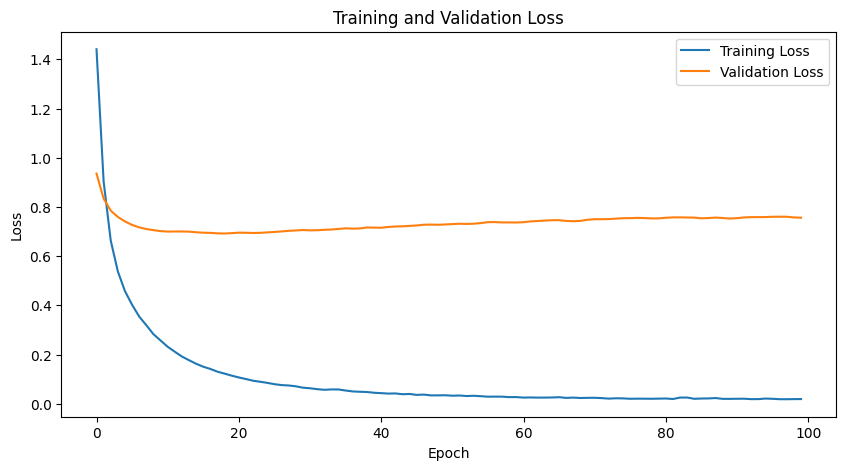

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_title('Training and Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

The loss plot seems to converge fast and follow the training set which is a sign of learning. As the validation loss has some significant distance from the training loss, the learning rate needs to be adjusted while the default of 0.001 seems to be high. Additionally, signs of overfitting are appearing while the two loss curves slowly diverge by time.

The above described problems can be managed on turning phase, by tuning the learning rate and the use or not of early stopping.

# Forecasting

In [64]:
# Predict the year 2023 on daily windows
yhat = model.predict(x_test)

12/12 [==============================] - 0s 2ms/step


In [65]:
# Reverse scaling
yhat[:, :]  = scaler.inverse_transform(yhat[:, :])

# Handling negative values if they exists in the forecast by setting them to 0
yhat = np.clip(yhat, a_min=0, a_max=None)

# Forecast evaluation

In [66]:
# Function to calculate RMSE
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [67]:
# Create a DataFrame with RMSE values and window timestamps
forecasted_df = pd.DataFrame({'timestamps': y_timestamp.flatten(), 'y_true': y_test.flatten(), 'y_hat': yhat.flatten()})

# Calculate the residuals
forecasted_df['residuals'] = forecasted_df['y_true'] - forecasted_df['y_hat']

In [68]:
# Calculate the overall RMSE
print(rmse(forecasted_df['y_true'],forecasted_df['y_hat']))

0.10454395118250145


Plot forecasted daily windows in different months

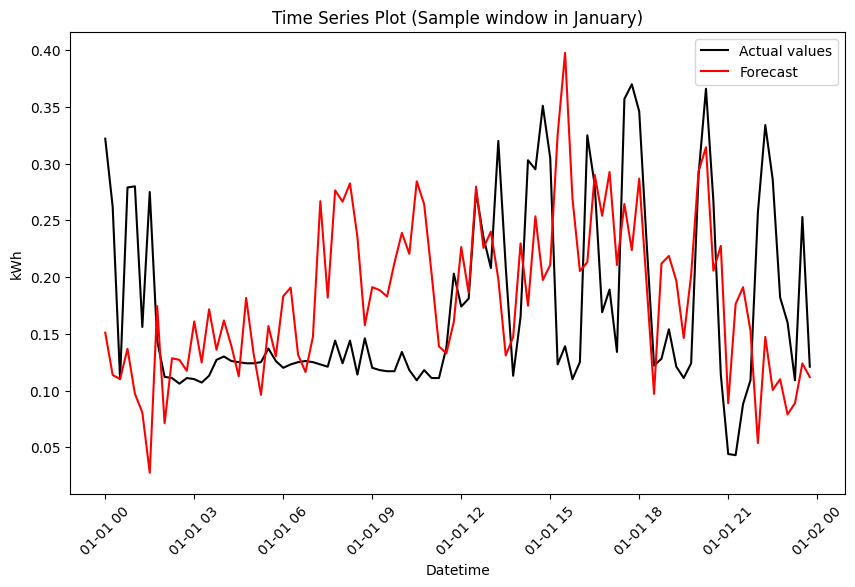

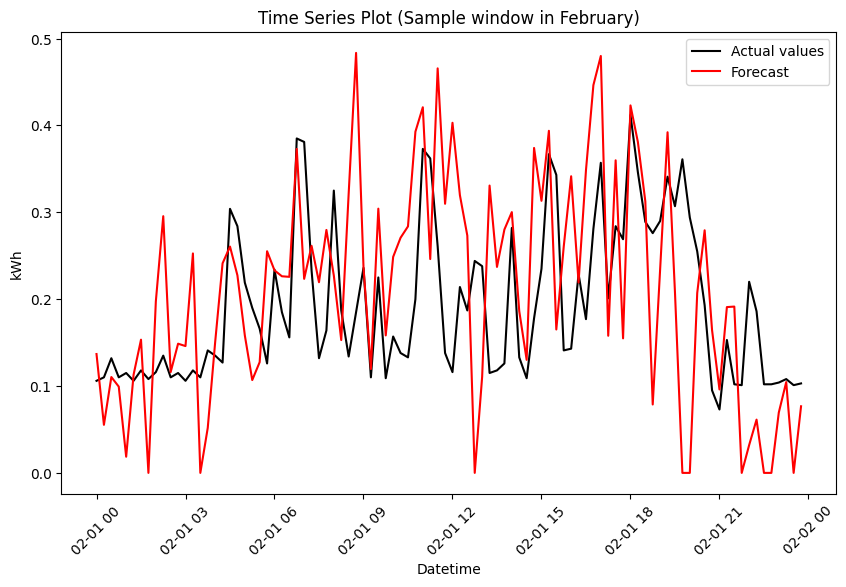

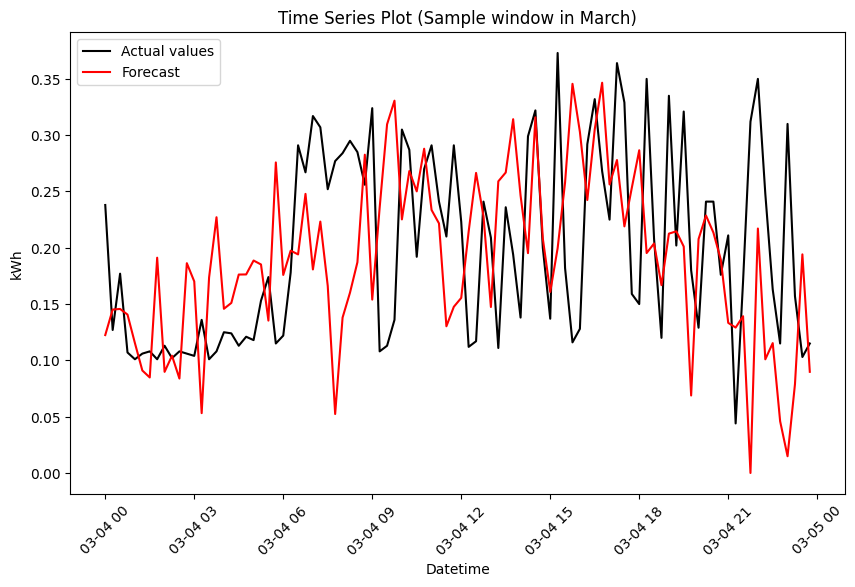

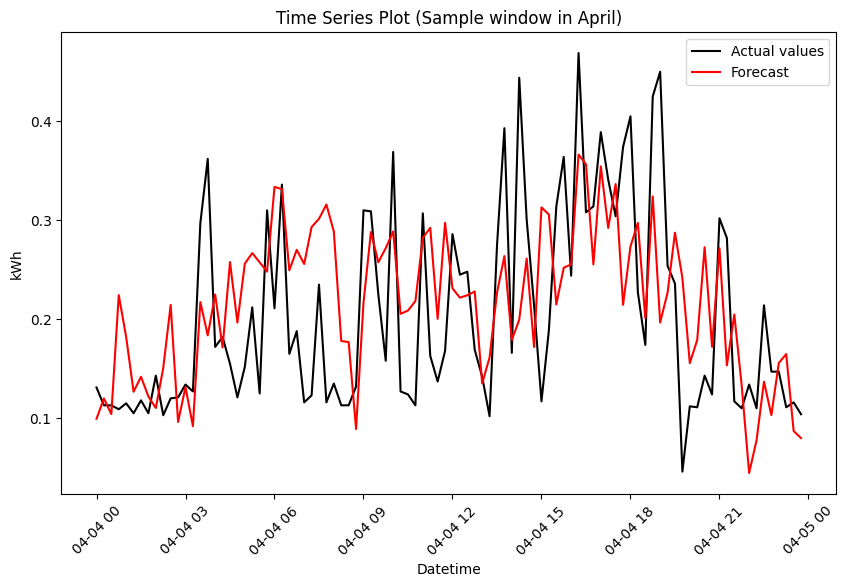

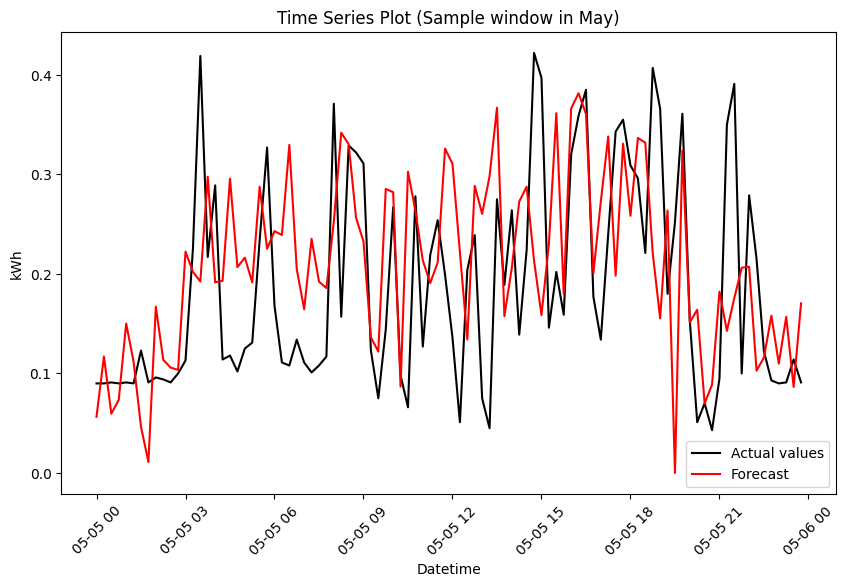

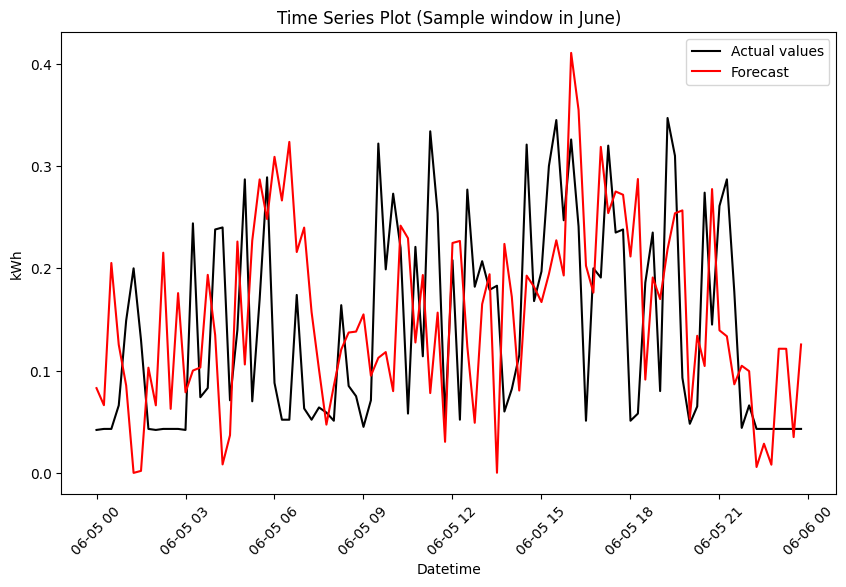

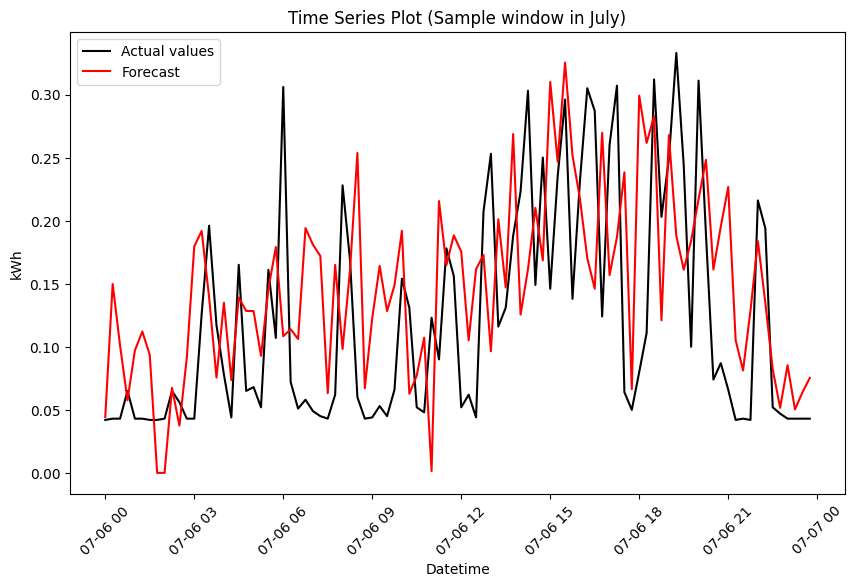

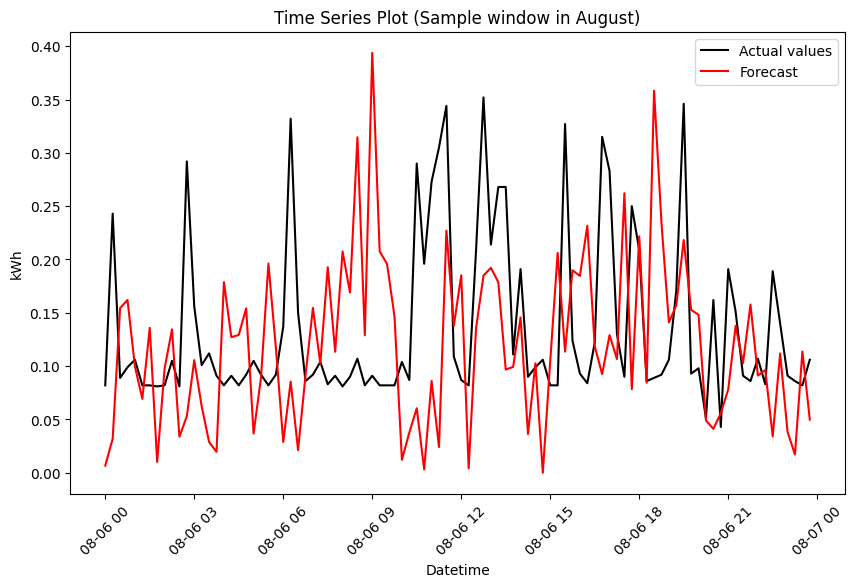

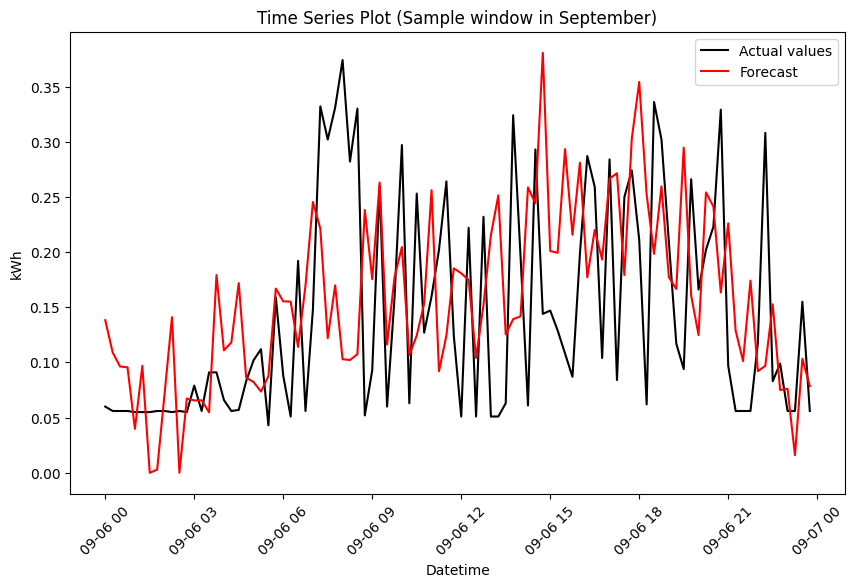

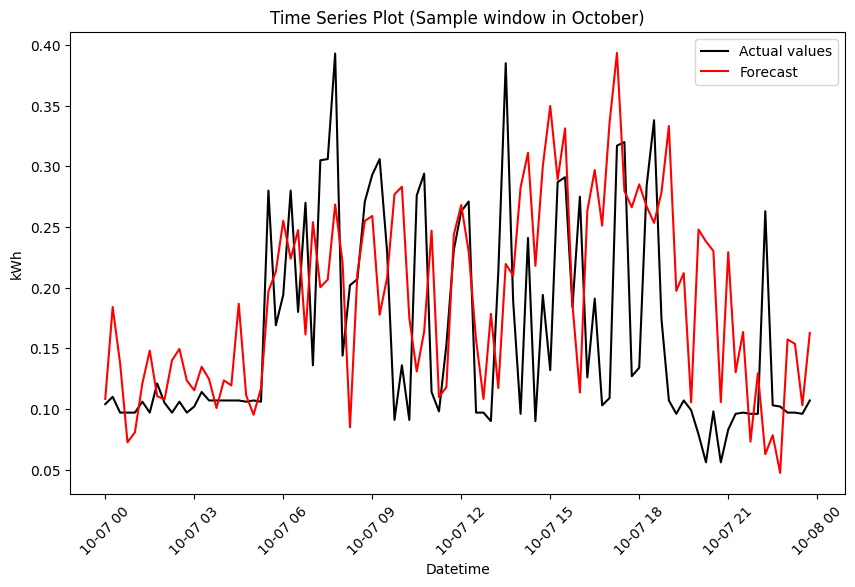

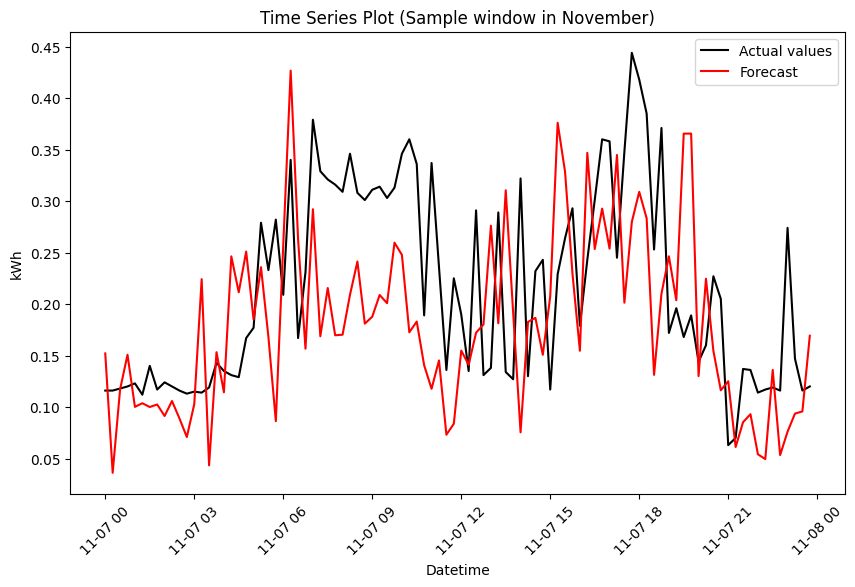

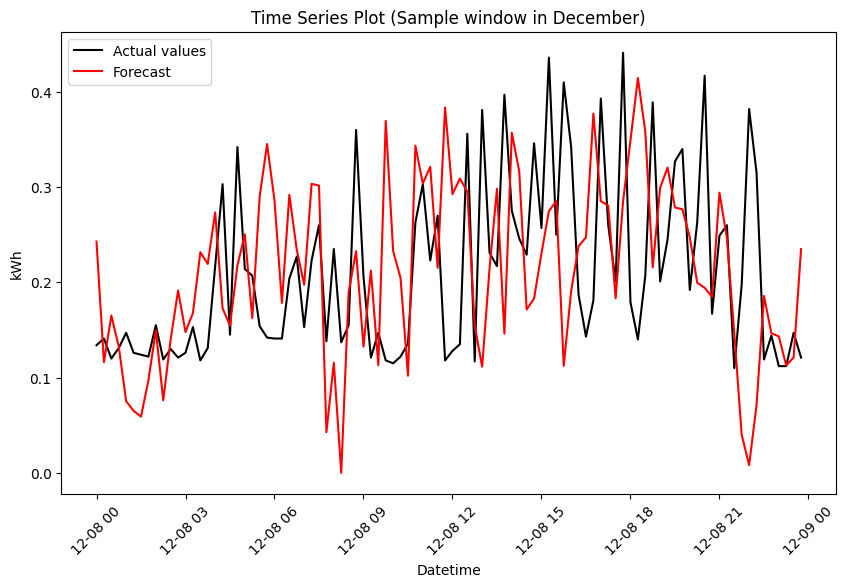

In [69]:
# Define window size and step
window_size = 96
step = 2976

# Calculate the total number of iterations
num_iterations = (len(forecasted_df) - window_size) // step + 1

# Plot each window
for i in range(num_iterations):
    start_idx = i * step
    end_idx = start_idx + window_size

    # Get month name
    start_month = forecasted_df['timestamps'].iloc[start_idx].month
    start_month_name = calendar.month_name[start_month]

    plt.figure(figsize=(10, 6))
    plt.plot(forecasted_df['timestamps'].iloc[start_idx:end_idx], forecasted_df['y_true'].iloc[start_idx:end_idx], label='Actual values', color='black')
    plt.plot(forecasted_df['timestamps'].iloc[start_idx:end_idx], forecasted_df['y_hat'].iloc[start_idx:end_idx], label='Forecast', color='red')

    # Add labels and title
    plt.xlabel('Datetime')
    plt.ylabel('kWh')
    plt.title(f'Time Series Plot (Sample window in {start_month_name})')

    # Add legend
    plt.legend()

    plt.xticks(rotation=45)

    # Show the plot
    plt.show()

The forecasts looks good while the model has captured the seasonality and trend and additionally the peaks on the daily windows.

# Residual analysis

The mean of the residuals is close to zero. As a first check for a good forecast the residual values should a mean of 0.

In [70]:
# Calculate and print the mean of the residuals
print(forecasted_df['residuals'].mean())

0.0005035296125742026


The histogram of the residuals shows a normal distribution, which indicates also a good forecast.

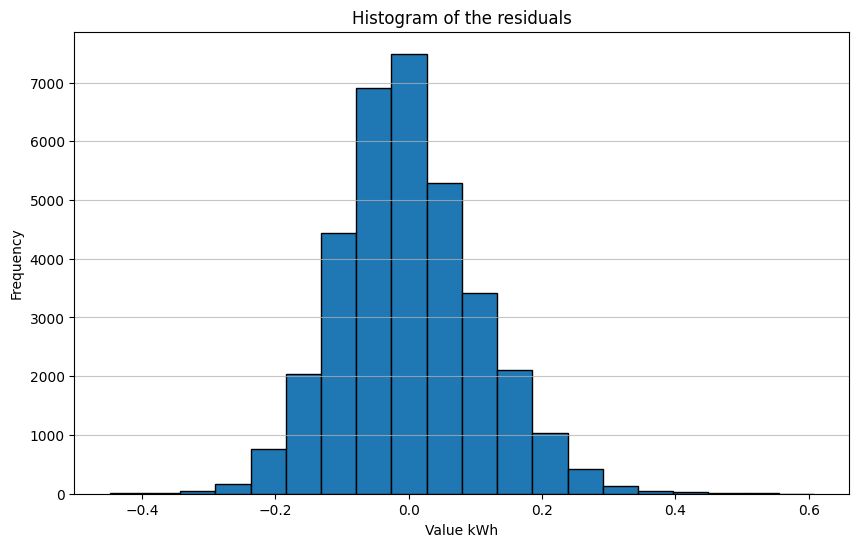

In [71]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(forecasted_df['residuals'], bins=20, edgecolor='black')
plt.title('Histogram of the residuals')
plt.xlabel('Value kWh')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

The ACF plot shows highly correlated values at lag 96 and its multiples, which means that there is further information in the residulas that needs to be modelled.

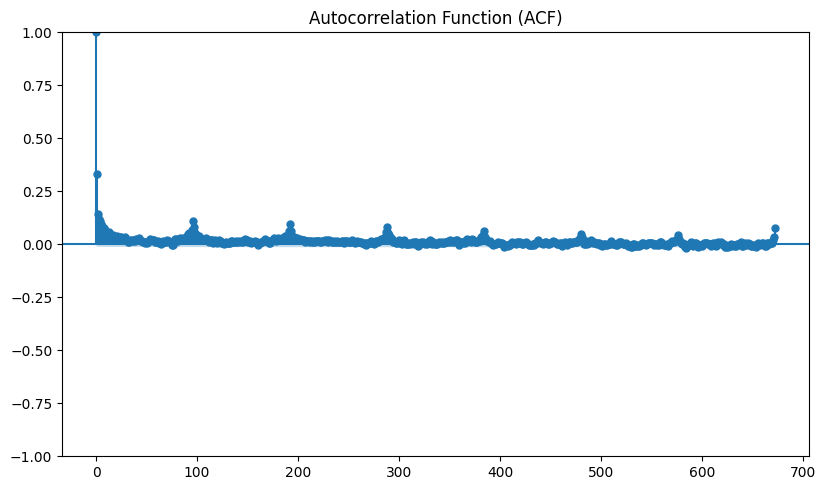

In [72]:
# Plotting ACF and PACF
plt.figure(figsize=(16, 5))

# ACF plot
plt.subplot(1, 2, 1)
plot_acf(forecasted_df['residuals'], lags=672, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

plt.tight_layout()
plt.show()

# Conclusions

1. The model behaves well but it has room for improvement
2. As a next step more data can be add on training the model and then more hidden layers to assess the behavior of the forecasts
3. Finally learning rate and use of early stopping can be tuned using tuning methods as Random Search.